In [21]:
import os
import ee
import datetime
import tqdm

import pandas as pd
import geopandas as gp
import numpy as np
import rsfuncs as rs

import scipy.interpolate as interp
import matplotlib.pyplot as plt

from tqdm import tqdm

ee.Initialize()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read files, make polygons
kc = pd.read_csv('../data/fmp_kc_faunt.csv')
gdf = gp.read_file("../shape/cv.shp")
data = rs.load_data()

# Split cv into polygons
area = rs.gdf_to_ee_poly(gdf.simplify(0.05))
polys = rs.gen_polys(area, dx = 0.25, dy = 0.25)
polydict = polys.getInfo()

In [3]:
# Ensure each poly is a single geometry 

valid_polys = []

for i in tqdm(polydict['features'][:]):
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
    pols = aoi.getInfo()['coordinates']
    if len(pols) == 0:
        continue
    if len(pols) == 1:
        valid_polys.append(ee.Geometry.Polygon(pols))
    if len(pols) > 1:
        for i in pols:
            valid_polys.append(ee.Geometry.Polygon(i))


100%|██████████| 391/391 [00:58<00:00,  6.73it/s]


In [4]:
# Helper functions 

def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']

    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = rs.array_from_df(df, var_name)
    
    return arr

def map_cdl2fmp(dictionary,array):
    '''maps values on cdl image to the fmp'''
    
    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        for i in v:
            if i == "":
                continue
            else:
                vec1.append(int(i))
                vec2.append(int(k))
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==k] =v
    
    return out_im


def map_fmp2kc(dictionary,array):
    '''maps values on fmp image to kc'''

    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        vec1.append(v)
        vec2.append(k)
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==v] =k
    
    return out_im


In [5]:
years = range(2001, 2020)
aoi = valid_polys[12]

for y in years[0:1]:
    
    yearstart = "{}-01-01".format(str(y))
    yearend = "{}-12-31".format(str(y))
    
    # Select the correct or most recent CDL
    if y < 2008:
        cdl = ee.Image("USDA/NASS/CDL/2008")
    else:
        cdl = ee.Image("USDA/NASS/CDL/{}".format(str(y)))
    
    if y < 2013: 
#         landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_ANNUAL_NDWI").filterDate(yearstart, yearend).sum()
        landsat = ee.ImageCollection("LANDSAT/LE07/C01/T1_32DAY_NDWI").filterDate(yearstart, yearend).mean()

    if y >= 2013: 
#         landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_ANNUAL_NDWI").filterDate(yearstart, yearend).sum()
        landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_32DAY_NDWI").filterDate(yearstart, yearend).mean()

    # Compile CDL
    cdl_dat = ee.Image.pixelLonLat().addBands(cdl).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    cdl_dict = cdl_dat.getInfo()
    
    # Compile landsat NDWI 
    landsat_dat = ee.Image.pixelLonLat().addBands(landsat).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    landsat_dict = landsat_dat.getInfo()
    
    # Make the ims 
    cdl_im = dict2arr(cdl_dict, 'cropland')
    ndwi_im = dict2arr(landsat_dict, "NDWI")
    
    # Map values from the CDL to the FMP
    fmpvals = []
    cdlvals = []

    mapping = rs.cdl_2_faunt()    
    fmp_im = map_cdl2fmp(mapping, cdl_im)
    
    # Map values from the FMP to kc (Schmid, 2004)    
    monthly_ims = []

    for i in kc.columns[2:]:
        kcvals = kc[i]
        kckeys =kc[kc.columns[0]]
        kcdict = dict(zip(kckeys, kcvals))
        kc_im = map_fmp2kc(kcdict, fmp_im)
        monthly_ims.append(kc_im)


In [6]:
# Plot images 

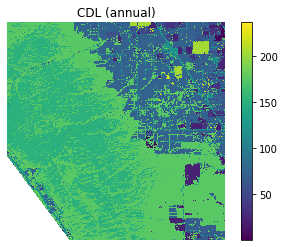

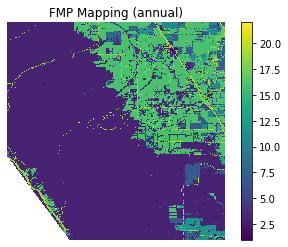

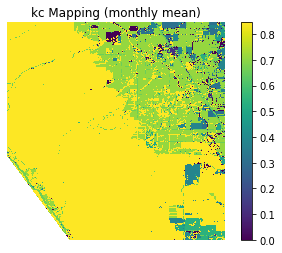

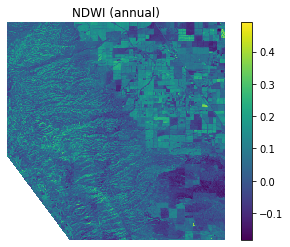

In [7]:
plt.title("CDL (annual)")
cdl_im[cdl_im == 0] = np.nan
plt.imshow(cdl_im)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("FMP Mapping (annual)")
fmp_im[fmp_im == 0] = np.nan
plt.imshow(fmp_im)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("kc Mapping (monthly mean)")
kc_mean = np.nanmean(np.dstack(monthly_ims), axis = 2)
kc_mean[ndwi_im == 0] = np.nan
plt.imshow(kc_mean)
plt.axis("off")
plt.colorbar()
plt.show()

plt.title("NDWI (annual)")
ndwi_im[ndwi_im == 0] = np.nan
plt.imshow(ndwi_im)
plt.axis("off")
plt.colorbar()
plt.show()



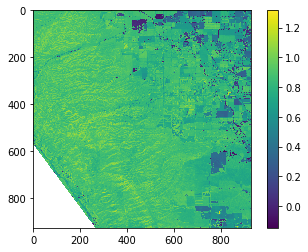

In [8]:
plt.imshow(kc_mean+ndwi_im)
plt.colorbar()

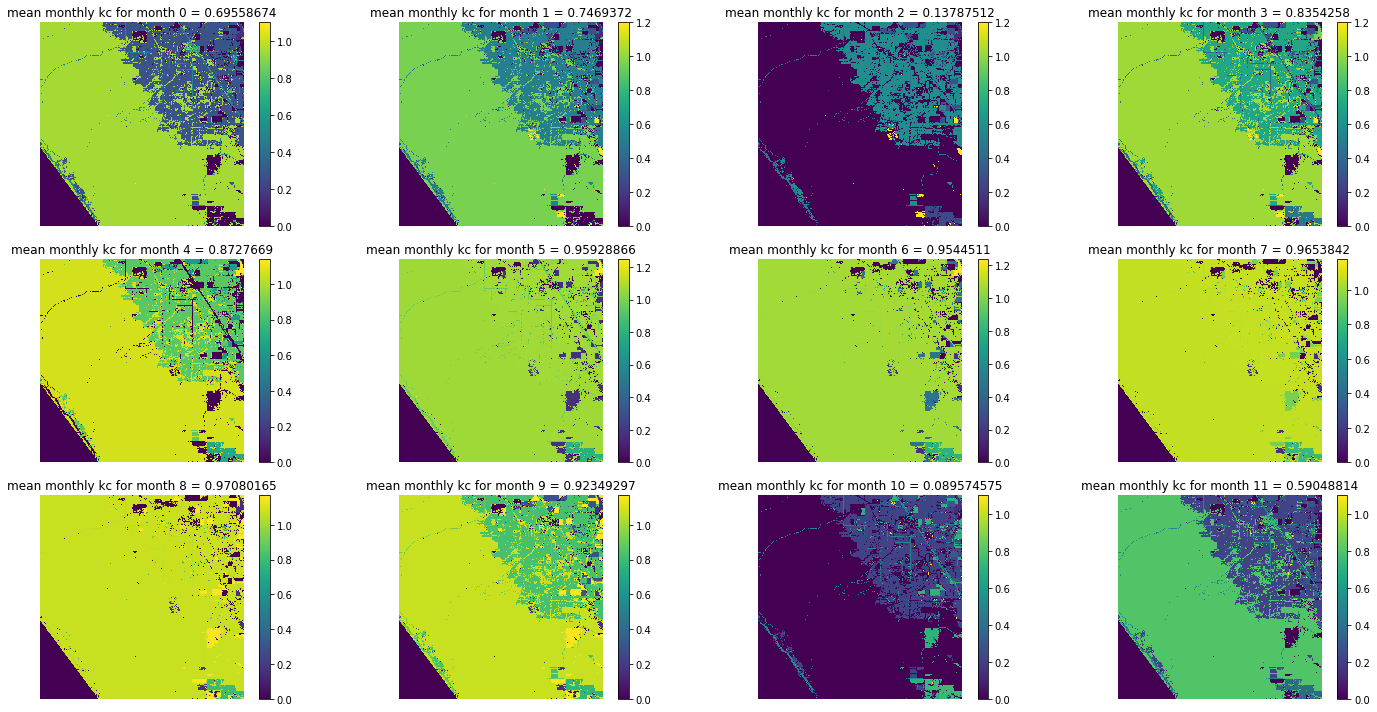

In [9]:
plt.figure(figsize=(20,10))

rows = 3
cols = 4

for idx,i in enumerate(monthly_ims):
    i[ndwi_im == np.nan] = np.nan
    plt.subplot(rows,cols,idx+1)
    plt.title("mean monthly kc for month {} = {}".format(str(idx),str(np.mean(i))))
    plt.axis('off')
    plt.imshow(i)
    plt.colorbar()
    
plt.tight_layout()

In [10]:
# Get aggregated stats and plot 

In [11]:
successes = 0
fails = 0

pets = []
aets = []

for i in tqdm(valid_polys[12:13]):
    pet = rs.calc_monthly_sum(data['modis_pet'], '2001-01-01','2001-12-31', i)
    aet = rs.calc_monthly_sum(data['modis_aet'], '2001-01-01','2001-12-31', i)

    pets.append(pet)
    aets.append(aet)
    
    if pet.sum().values == 0:
        fails +=1 
    else:
        successes +=1
        
    print("success = {}".format(successes))
    print("fails = {}".format(fails))
    

  0%|          | 0/1 [00:00<?, ?it/s]

processing:
MODIS/006/MOD16A2/2001_01_01



processing:
MODIS/006/MOD16A2/2001_01_01


100%|██████████| 1/1 [00:15<00:00, 15.88s/it]


success = 1
fails = 0


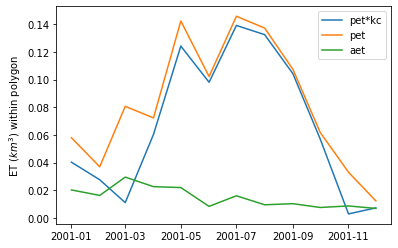

In [12]:
kc_means = np.array([np.mean(x) for x in monthly_ims])
plt.plot(kc_means.reshape(kc_means.shape[0],1)* pets[0], label = 'pet*kc')
plt.plot(pets[0], label = 'pet')
plt.plot(aets[0], label = "aet")

plt.ylabel("ET ($km^3$) within polygon")
plt.legend()

In [13]:
valid_polys[12].getInfo()

{'type': 'Polygon',
 'coordinates': [[[-122.17587589077269, 38.79939515288074],
   [-121.99767790847199, 38.799340626839474],
   [-121.99767790847199, 39.049340626839474],
   [-122.24767790847199, 39.049340626839474],
   [-122.24767790847199, 38.89585363003154],
   [-122.17587589077269, 38.79939515288074]]]}

In [14]:
def normalize_array(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))


In [15]:
# Interpoalte modis onto landsat resolution data 

def normalize_array(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))


In [16]:
def get_monthly_et(dataset, start, end, aoi):
    '''
    
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]
    
    dt_idx = pd.date_range(start,end, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()
    
    for i in tqdm(num_steps[:]):

        start = ee.Date(yearstart).advance(i, 'month')
        end = start.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(start, end).sum().set('system:time_start', start.millis()))
        modis_dat = im.pixelLonLat().addBands(im).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=1000)
        modis_dict = modis_dat.getInfo()
        modis_im = dict2arr(modis_dict, var)
        ims.append(modis_im)
        
    return ims

def resample_1km_30m(im_1km,im_30m):
    '''
    Interpolates 1 km modis data on to 30m landsat grid
    
    '''
    
    W, H = im_1km.shape[:2]
    new_W, new_H = im_30m.shape[:2]
    xrange = lambda x: np.linspace(0, 1, x)

    f = interp.interp2d(xrange(W), xrange(H), im_1km, kind="linear")
    new_arr = f(xrange(new_H), xrange(new_W))
    
    return new_arr
    

In [17]:
aetims = get_monthly_et(data['modis_aet'], '2001-01-01', '2001-12-31', aoi = valid_polys[12])
petims = get_monthly_et(data['modis_pet'], '2001-01-01', '2001-12-31', aoi = valid_polys[12])

100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


<ipython-input-18-28e42e95ab57>:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(np.dstack(aetims), axis = 2))


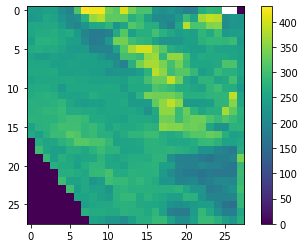

<ipython-input-18-28e42e95ab57>:4: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(np.dstack(petims), axis = 2))


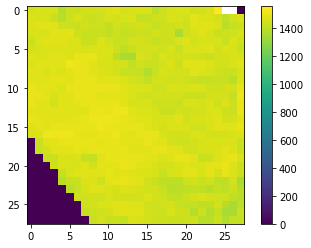

In [18]:
plt.imshow(np.nanmean(np.dstack(aetims), axis = 2))
plt.colorbar()
plt.show()
plt.imshow(np.nanmean(np.dstack(petims), axis = 2))
plt.colorbar()
plt.show()

In [19]:
petmean = np.nanmean(np.dstack(petims), axis = 2)
aetmean = np.nanmean(np.dstack(aetims), axis = 2)

<ipython-input-19-8da8dc470c79>:1: RuntimeWarning: Mean of empty slice
  petmean = np.nanmean(np.dstack(petims), axis = 2)
<ipython-input-19-8da8dc470c79>:2: RuntimeWarning: Mean of empty slice
  aetmean = np.nanmean(np.dstack(aetims), axis = 2)


In [22]:
pet_rs = resample_1km_30m(petmean, kc_mean)
aet_rs = resample_1km_30m(aetmean, kc_mean)

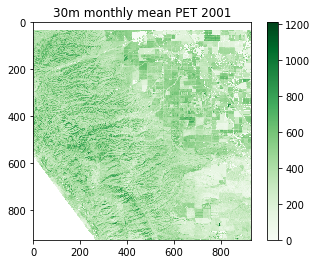

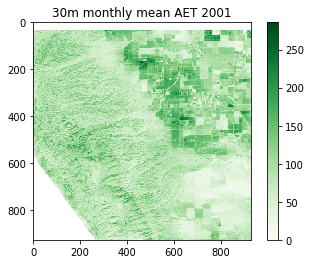

In [24]:
plt.imshow(pet_rs*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean PET 2001")
plt.show()
plt.imshow(aet_rs*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean AET 2001")
plt.show()

In [ ]:
plt.imshow(1-normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()

In [ ]:
plt.imshow(( aet_rs*(1-normalize_array(ndwi_im)*kc_mean)) + (pet_rs *(normalize_array(ndwi_im)*kc_mean)) / 2, cmap = 'Greens')
plt.colorbar()

<ipython-input-44-56603db4b92e>:17: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(np.dstack(petims), axis = 2), cmap = 'jet')
<ipython-input-44-56603db4b92e>:42: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(np.dstack(aetims), axis = 2), cmap = 'jet')


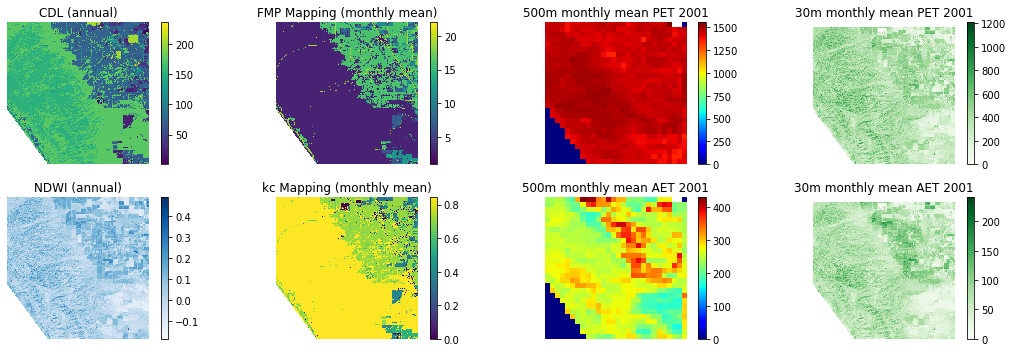

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(241)
plt.title("CDL (annual)")
plt.imshow(cdl_im)
plt.axis("off")
plt.colorbar()

plt.subplot(242)
plt.title("FMP Mapping (monthly mean)")
plt.imshow(fmp_im)
plt.axis("off")
plt.colorbar()

plt.subplot(243)
plt.title("500m monthly mean PET 2001")
plt.imshow(np.nanmean(np.dstack(petims), axis = 2), cmap = 'jet')
plt.colorbar()
plt.axis("off")

plt.subplot(244)
plt.imshow(pet_rs*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean PET 2001")
plt.axis("off")

plt.subplot(245)
plt.title("NDWI (annual)")
plt.imshow(ndwi_im, cmap = "Blues")
plt.axis("off")
plt.colorbar()


plt.subplot(246)
plt.title("kc Mapping (monthly mean)")
plt.imshow(kc_mean)
plt.axis("off")
plt.colorbar()

plt.subplot(247)
plt.title("500m monthly mean AET 2001")
plt.imshow(np.nanmean(np.dstack(aetims), axis = 2), cmap = 'jet')
plt.colorbar()
plt.axis("off")

plt.subplot(248)
plt.imshow(aet_rs*kc_mean*normalize_array(ndwi_im), cmap = 'Greens')
plt.colorbar()
plt.title("30m monthly mean AET 2001")
plt.axis("off")


plt.tight_layout()
plt.show()


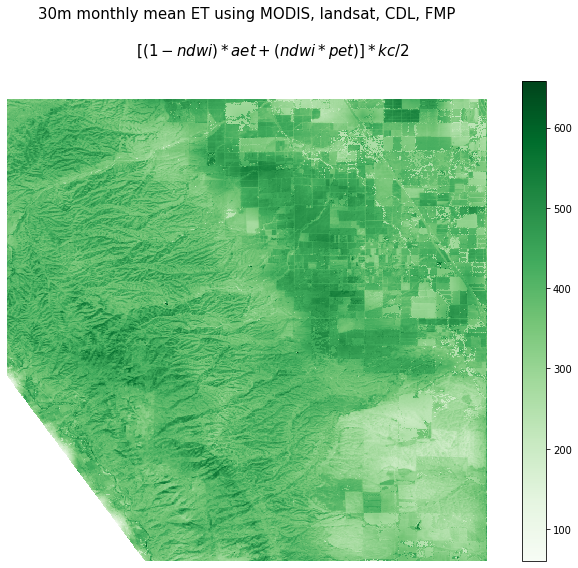

In [50]:
plt.figure(figsize=(10,8))
plt.suptitle("")
plt.title("""30m monthly mean ET using MODIS, landsat, CDL, FMP

           $ [(1-ndwi)*aet + (ndwi * pet)] * kc / 2 $
            """, size = 15)
plt.imshow(( aet_rs*(1-normalize_array(ndwi_im)*kc_mean)) + (pet_rs *(normalize_array(ndwi_im)*kc_mean)) / 2, cmap = 'Greens')

plt.axis("off")
plt.colorbar()
plt.tight_layout()
plt.show()

In [265]:
dataset = data['modis_aet']

ImageCollection = dataset[0]
var = dataset[1]
scaling_factor = dataset[2]
resolution = dataset[3]
    
dt_idx = pd.date_range(yearstart,yearend, freq='MS')
ims = []
seq = ee.List.sequence(0, len(dt_idx)-1)
num_steps = seq.getInfo()

for i in num_steps[8:9]:

    start = ee.Date(yearstart).advance(i, 'month')
    end = start.advance(1, 'month');

    im = ee.Image(ImageCollection.select(var).filterDate(start, end).sum().set('system:time_start', start.millis()))

In [266]:
modis_dat = im.pixelLonLat().addBands(im).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=1000)
modis_dict = modis_dat.getInfo()
modis_im = dict2arr(modis_dict, var)

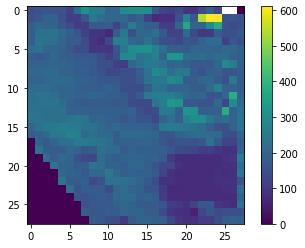

In [267]:
plt.imshow(modis_im)
plt.colorbar()

In [268]:
import scipy.interpolate as interp

W, H = modis_im.shape[:2]
new_W, new_H = kc_mean.shape[:2]
xrange = lambda x: np.linspace(0, 1, x)

f = interp.interp2d(xrange(W), xrange(H), modis_im, kind="linear")
new_arr = f(xrange(new_H), xrange(new_W))

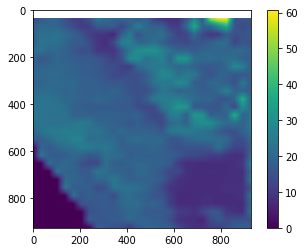

In [269]:
plt.imshow(new_arr*0.1)
plt.colorbar()

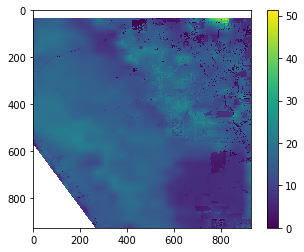

In [270]:
plt.imshow(kc_mean*new_arr*0.1)
plt.colorbar()

In [211]:
np.nansum(kc_mean*new_arr*0.1) * 1e-9 * 28**2

48.68399870662453

In [38]:
plt.imshow(np.nanmean(np.dstack(pet_ims), axis = 2))
plt.colorbar()
plt.show()
plt.imshow(np.nanmean(np.dstack(aet_ims), axis = 2))
plt.colorbar()
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 160 and the array at index 1 has size 163

In [ ]:
def get_ims(dataset, startdate,enddate, area, return_dates = False, table = False, monthly_mean = False,  monthly_sum = False):
    
    '''
    Returns gridded images for EE datasets 
    '''

    if monthly_mean:
        if monthly_sum:
            raise ValueError("cannot perform mean and sum reduction at the same time")              

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    native_res = dataset[3]

    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()

    # TODO: Make this one loop ?

    print("processing:")
    print("{}".format(ImageCollection.first().getInfo()['id']))

    for i in tqdm(num_steps):

        start = ee.Date(startdate).advance(i, 'month')
        end = start.advance(1, 'month');

        if monthly_mean:
            im1 = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).mean().set('system:time_start', end.millis())
            im = ee.ImageCollection(im1)
        elif monthly_sum:
            im1 = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', end.millis())
            im = ee.ImageCollection(im1)
        else:
            im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).set('system:time_start', end.millis())
        
        result = im.getRegion(area,native_res,"epsg:4326").getInfo()
        ims.append(result)

    return ims
    results = []
    dates = []

    print("postprocesing")

    for im in ims:
        header, data = im[0], im[1:]

        df = pd.DataFrame(np.column_stack(data).T, columns = header)
        df.latitude = pd.to_numeric(df.latitude)
        df.longitude = pd.to_numeric(df.longitude)
        df[var] = pd.to_numeric(df[var])

        if table:
            results.append(df)
            continue

        images = []

        for idx,i in enumerate(df.id.unique()):

            t1 = df[df.id==i]
            arr = array_from_df(t1,var)
            arr[arr == 0] = np.nan
            images.append(arr*scaling_factor)# This is the only good place to apply the scaling factor. 

            if return_dates:
                date = df.time.iloc[idx]
                dates.append(datetime.datetime.fromtimestamp(date/1000.0))

        results.append(images) 

    print("====COMPLETE=====")

    # Unpack the list of results 
    if return_dates:
        return [ [item for sublist in results for item in sublist], dates]
    else:   
        return [item for sublist in results for item in sublist] 


